In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gdp
import glob 
import os
import statsmodels.api as sm
import seaborn as sns


In [12]:

# Define paths to NDVI and VIIRS folders
ndvi_folder = r"C:\Users\aadit\ECON4997\EVI by District"
viirs_folder = r"C:\Users\aadit\ECON4997\Nightlights by district"

# Load all NDVI files
ndvi_files = glob.glob(os.path.join(ndvi_folder, "*.csv"))
ndvi_dfs = [pd.read_csv(file) for file in ndvi_files]
ndvi_df = pd.concat(ndvi_dfs, ignore_index=True)

# Load all VIIRS files
viirs_files = glob.glob(os.path.join(viirs_folder, "*.csv"))
viirs_dfs = [pd.read_csv(file) for file in viirs_files]
viirs_df = pd.concat(viirs_dfs, ignore_index=True)

# Convert 'date' column to datetime format
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
viirs_df['date'] = pd.to_datetime(viirs_df['date'])

ndvi_df['mean_evi'] = ndvi_df['mean_evi'] *.0001

# Ensure data is sorted correctly for panel structure
ndvi_df = ndvi_df.sort_values(by=['ADMIN_NAME', 'year', 'month'])
viirs_df = viirs_df.sort_values(by=['ADMIN_NAME', 'year', 'month'])


In [13]:

# Function to compute summary statistics
def panel_summary(df, value_column):
    # Overall summary statistics
    overall_summary = df[value_column].describe()

    # Between variation (std of district means)
    between_var = df.groupby('ADMIN_NAME')[value_column].mean().std()

    # Within variation (deviation from district mean)
    df['group_mean'] = df.groupby('ADMIN_NAME')[value_column].transform('mean')
    df['within_var'] = df[value_column] - df['group_mean']
    within_var = df['within_var'].std()

    # First differences (checking stationarity)
    df['first_diff'] = df.groupby('ADMIN_NAME')[value_column].diff()

    # Aggregated statistics by country and year
    grouped_summary = df.groupby(['CNTRY_NAME', 'year'])[value_column].describe()

    return overall_summary, between_var, within_var, df['first_diff'].describe(), grouped_summary


In [14]:
# Compute summary statistics for NDVI (mean_evi)
ndvi_summary = panel_summary(ndvi_df, 'mean_evi')

# Compute summary statistics for VIIRS (mean_rad)
viirs_summary = panel_summary(viirs_df, 'mean_rad')

# Print results
print("NDVI Summary Statistics:\n", ndvi_summary[0])
print("\nNDVI Between Variation:", ndvi_summary[1])
print("\nNDVI Within Variation:", ndvi_summary[2])
print("\nNDVI First Differences:\n", ndvi_summary[3])
print("\nNDVI Grouped Summary:\n", ndvi_summary[4])

print("\n\nVIIRS Summary Statistics:\n", viirs_summary[0])
print("\nVIIRS Between Variation:", viirs_summary[1])
print("\nVIIRS Within Variation:", viirs_summary[2])
print("\nVIIRS First Differences:\n", viirs_summary[3])
print("\nVIIRS Grouped Summary:\n", viirs_summary[4])


NDVI Summary Statistics:
 count    1800.000000
mean        0.197328
std         0.076500
min         0.087341
25%         0.145761
50%         0.167790
75%         0.225348
max         0.531926
Name: mean_evi, dtype: float64

NDVI Between Variation: 0.028657222443738806

NDVI Within Variation: 0.07131173047474608

NDVI First Differences:
 count    1785.000000
mean        0.000146
std         0.053392
min        -0.176326
25%        -0.022945
50%        -0.007142
75%         0.011099
max         0.191931
Name: first_diff, dtype: float64

NDVI Grouped Summary:
                  count      mean       std       min       25%       50%  \
CNTRY_NAME year                                                            
Ethiopia   2014  108.0  0.177316  0.065502  0.087341  0.131970  0.148109   
           2015  108.0  0.165407  0.052526  0.095674  0.130875  0.149022   
           2016  108.0  0.178387  0.062187  0.096206  0.135474  0.158570   
           2017  108.0  0.178765  0.053549  0.107979  

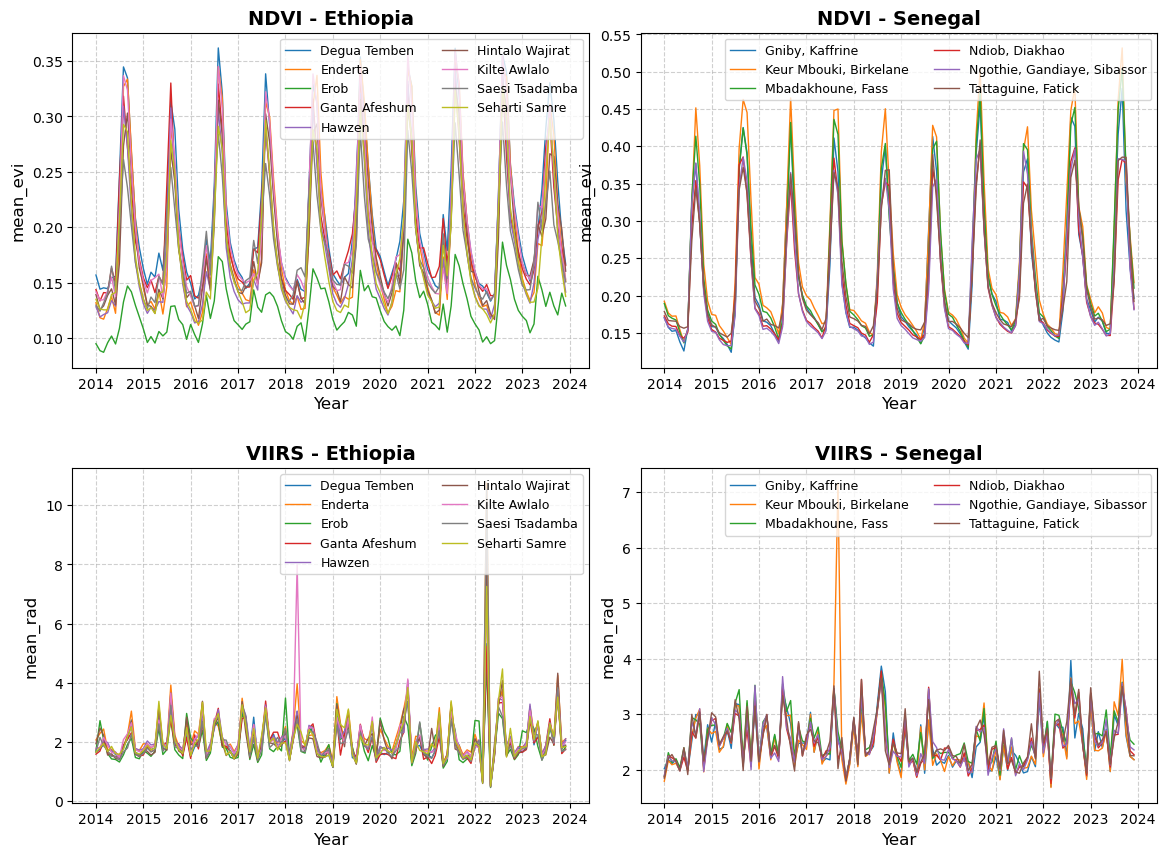

In [15]:
# Create a more spacious layout for better differentiation of district lines
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Increase figure size

# Define plot settings
metrics = [('NDVI', 'mean_evi', ndvi_df), ('VIIRS', 'mean_rad', viirs_df)]
countries = ['Ethiopia', 'Senegal']

# Iterate over metrics and countries
for i, (metric, value_column, df) in enumerate(metrics):
    for j, country in enumerate(countries):
        ax = axes[i, j]
        
        # Filter data for country
        country_df = df[df['CNTRY_NAME'] == country]
        
        # Plot each district's time series
        for k, (district, district_df) in enumerate(country_df.groupby('ADMIN_NAME')):
            ax.plot(district_df['date'], district_df[value_column], label=district, linewidth=1)
        
        # Formatting
        ax.set_title(f"{metric} - {country}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel(value_column, fontsize=12)
        ax.legend(fontsize=9, loc='upper right', frameon=True, ncol=2)
        ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to provide more space
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


In [16]:

# Merge NDVI and VIIRS datasets on country, district, and date
merged_df = pd.merge(ndvi_df, viirs_df, on=['CNTRY_NAME', 'ADMIN_NAME', 'date', 'year', 'month'], how='inner')
# Check the first few rows of the merged dataframe
print(merged_df.head())

# Check the number of rows before and after merging
print(f"NDVI dataset size: {ndvi_df.shape[0]} rows")
print(f"VIIRS dataset size: {viirs_df.shape[0]} rows")
print(f"Merged dataset size: {merged_df.shape[0]} rows")

# Check for missing values in the merged dataset
print("Missing values in merged dataset:")
print(merged_df.isnull().sum())

# Check if all expected countries and districts are present after merging
print("Unique countries in merged dataset:", merged_df['CNTRY_NAME'].unique())
print("Unique districts count:", merged_df['ADMIN_NAME'].nunique())

# Check if the date range aligns properly
print(f"Date range in merged dataset: {merged_df['date'].min()} to {merged_df['date'].max()}")

# Ensure no duplicate rows exist after merging
print(f"Duplicate rows in merged dataset: {merged_df.duplicated().sum()}")


  system:index_x    ADMIN_NAME  CNTRY_CODE_x CNTRY_NAME  IPUM2007_x  PARENT_x  \
0            0_0  Degua Temben           231   Ethiopia   1002009.0      1002   
1            0_1  Degua Temben           231   Ethiopia   1002009.0      1002   
2            0_2  Degua Temben           231   Ethiopia   1002009.0      1002   
3            0_3  Degua Temben           231   Ethiopia   1002009.0      1002   
4            0_4  Degua Temben           231   Ethiopia   1002009.0      1002   

   WERE2007_x       date  mean_evi  month  ...  IPUM2007_y PARENT_y  \
0     10209.0 2014-01-01  0.157028      1  ...   1002009.0     1002   
1     10209.0 2014-02-01  0.144261      2  ...   1002009.0     1002   
2     10209.0 2014-03-01  0.145485      3  ...   1002009.0     1002   
3     10209.0 2014-04-01  0.144699      4  ...   1002009.0     1002   
4     10209.0 2014-05-01  0.154478      5  ...   1002009.0     1002   

   WERE2007_y  mean_rad                                             .geo_y  \
0     10

In [17]:


# Define function to run pooled OLS regression for each country
def run_pooled_regression(df, country):
    country_df = df[df['CNTRY_NAME'] == country].copy()

    # Define dependent (Y) and independent (X) variables
    Y = country_df['mean_rad']  # VIIRS as predictor
    X = country_df['mean_evi']  # NDVI as response
    
    # Add constant for OLS regression
    X = sm.add_constant(X)
    
    # Run OLS regression
    model = sm.OLS(Y, X).fit()
    
    return model.summary()


In [18]:

# Run regression for Ethiopia and Senegal
ethiopia_regression = run_pooled_regression(merged_df, "Ethiopia")

# Print results
print("Pooled OLS Regression - Ethiopia:\n", ethiopia_regression)


Pooled OLS Regression - Ethiopia:
                             OLS Regression Results                            
Dep. Variable:               mean_rad   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     22.06
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           2.98e-06
Time:                        16:44:59   Log-Likelihood:                -1302.4
No. Observations:                1080   AIC:                             2609.
Df Residuals:                    1078   BIC:                             2619.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.

In [19]:
senegal_regression = run_pooled_regression(merged_df, "Senegal")
print("\nPooled OLS Regression - Senegal:\n", senegal_regression)


Pooled OLS Regression - Senegal:
                             OLS Regression Results                            
Dep. Variable:               mean_rad   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     87.25
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           1.18e-19
Time:                        16:44:59   Log-Likelihood:                -462.37
No. Observations:                 720   AIC:                             928.7
Df Residuals:                     718   BIC:                             937.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.

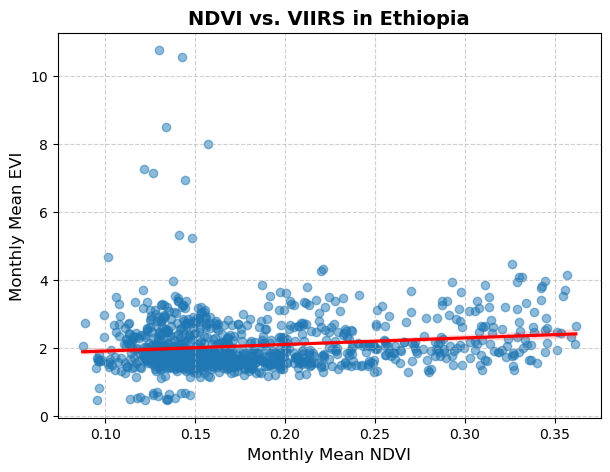

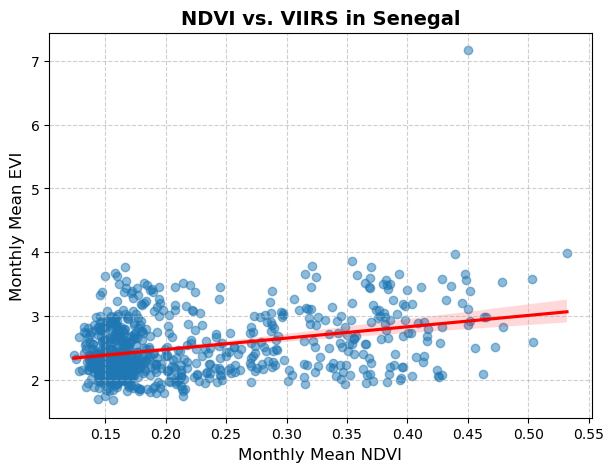

In [20]:


# Define function to plot scatterplots for each country
def plot_regression_scatter(df, country):
    country_df = df[df['CNTRY_NAME'] == country].copy()

    # Scatter plot with regression line
    plt.figure(figsize=(7, 5))
    sns.regplot(x=country_df['mean_evi'], y=country_df['mean_rad'], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    
    # Formatting
    plt.title(f"NDVI vs. VIIRS in {country}", fontsize=14, fontweight='bold')
    plt.xlabel("Monthly Mean NDVI", fontsize=12)
    plt.ylabel("Monthly Mean EVI", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Show plot
    plt.show()

# Plot scatterplots for Ethiopia and Senegal
plot_regression_scatter(merged_df, "Ethiopia")
plot_regression_scatter(merged_df, "Senegal")


c:\Users\aadit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aadit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


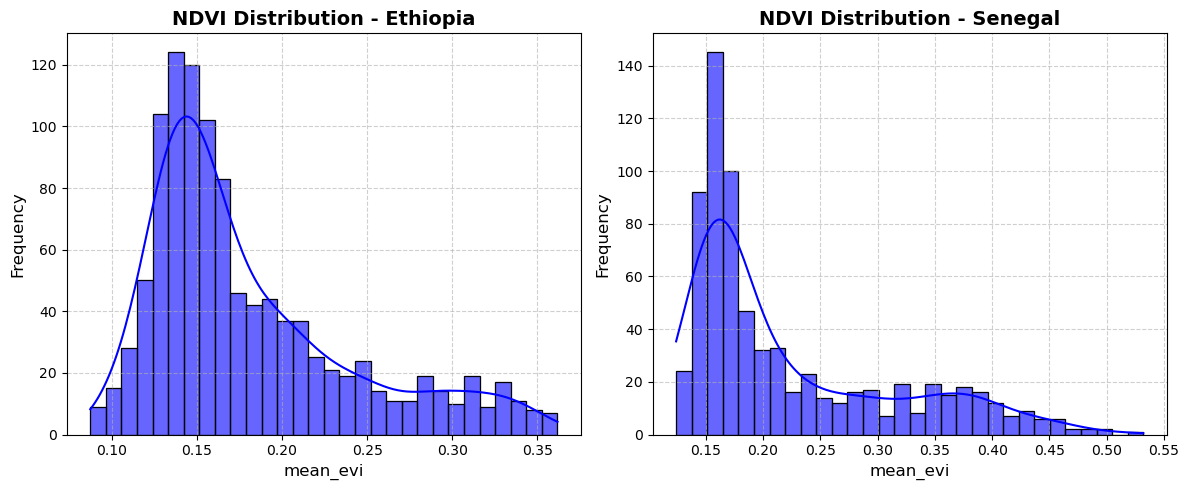

c:\Users\aadit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aadit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


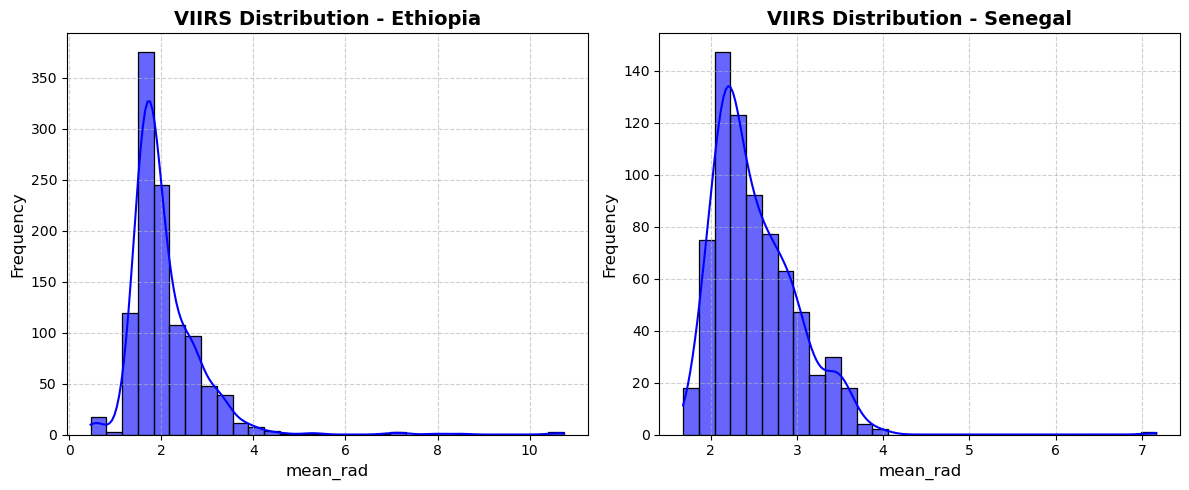

In [21]:


# Define function to plot histograms for NDVI and VIIRS in both countries
def plot_histograms(df, value_column, metric_name):
    countries = ['Ethiopia', 'Senegal']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Side-by-side histograms
    
    for i, country in enumerate(countries):
        ax = axes[i]
        
        # Filter data for country
        country_df = df[df['CNTRY_NAME'] == country]
        
        # Plot histogram with KDE (density estimate)
        sns.histplot(country_df[value_column], bins=30, kde=True, ax=ax, color='blue', alpha=0.6)
        
        # Formatting
        ax.set_title(f"{metric_name} Distribution - {country}", fontsize=14, fontweight='bold')
        ax.set_xlabel(value_column, fontsize=12)
        ax.set_ylabel("Frequency", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Plot histograms for NDVI (mean_evi) and VIIRS (mean_rad)
plot_histograms(ndvi_df, 'mean_evi', 'NDVI')
plot_histograms(viirs_df, 'mean_rad', 'VIIRS')
